ЛР2 логистическая и линейная регрессия Phishing Websites и CCPP

В этой лр применяются логистическая регрессия для классификации фишинговых сайтов и линейная регрессия для прогноза выработки электростанции(такие же датасеты, как и для первой), строятся базовые модели, затем улучшаются и реализуются простые версии с нуля для сравнения

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet


Данные для классификации Phishing Websites OpenML id 4534

In [2]:
# Загружаем Phishing с OpenML и готовим признаки и цель, потому что так корректно считаются метрики и выполняется стратифицированный сплит
ds = fetch_openml(data_id=4534, as_frame=True)
df = ds.frame.copy()

y_cls = (df['Result'].astype(int) == 1).astype(int).to_numpy()
X_cls = df.drop(columns=['Result']).replace('?', np.nan).apply(pd.to_numeric, errors='coerce')

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

print('Баланс классов train:', np.unique(yc_train, return_counts=True))
print('Баланс классов test :', np.unique(yc_test, return_counts=True))


Баланс классов train: (array([0, 1]), array([3918, 4926], dtype=int64))
Баланс классов test : (array([0, 1]), array([ 980, 1231], dtype=int64))


Данные для регрессии Combined Cycle Power Plant CCPP

Читаем таблицу Folds5x2_pp.xlsx где целевой признак PE это выходная мощность а остальные переменные входные факторы среды

In [5]:
import os

# Загружаем CCPP из файла и делим выборку, целевая переменная находится в столбце PE.
reg_path = '../datasets/Folds5x2_pp.xlsx'
if not os.path.exists(reg_path):
    raise FileNotFoundError("File Folds5x2_pp.xlsx not found")

df_reg = pd.read_excel(reg_path)

y_reg = df_reg['PE'].to_numpy()
X_reg = df_reg.drop(columns=['PE'])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print('Размеры train и test:', Xr_train.shape, Xr_test.shape)


Размеры train и test: (7654, 4) (1914, 4)


Бейзлайн и оценка качества

Строим простые модели логистическая регрессия для классификации и линейная регрессия для регрессии чтобы получить отправную точку качества.

Бейзлайн классификация: {'Accuracy': 0.9285391225689733, 'MacroF1': 0.9273144086995168, 'ROC-AUC': 0.9808020689998175}


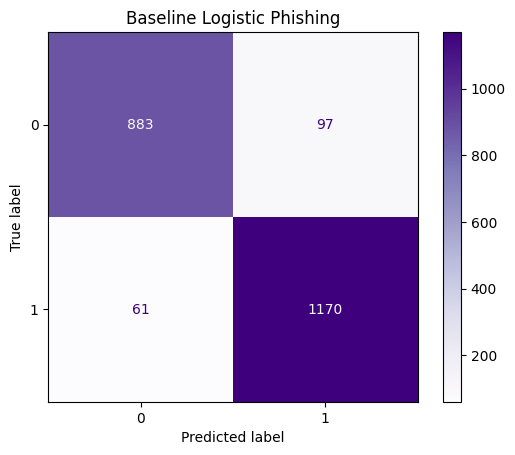

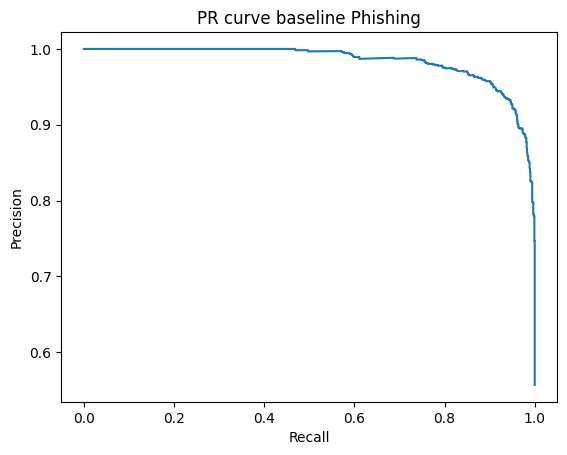

In [6]:
# Обучаем логистическую регрессию в пайплайне с импьютацией и стандартизацией, потому что это снижает утечки и стабилизирует оптимизацию
pipe_logreg_base = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200))
])
pipe_logreg_base.fit(Xc_train, yc_train)

yc_pred = pipe_logreg_base.predict(Xc_test)
yc_proba = pipe_logreg_base.predict_proba(Xc_test)[:, 1]

base_cls = {
    'Accuracy': accuracy_score(yc_test, yc_pred),
    'MacroF1': f1_score(yc_test, yc_pred, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, yc_proba)
}
print('Бейзлайн классификация:', base_cls)

cm = confusion_matrix(yc_test, yc_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap='Purples')
plt.title('Baseline Logistic Phishing')
plt.show()

prec, rec, thr = precision_recall_curve(yc_test, yc_proba)
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve baseline Phishing')
plt.show()


Далее обучаем линейную регрессию как базовый ориентир перед регуляризацией и нелинейными признаками, тк так проще увидеть эффект улучшений

Бейзлайн регрессия: {'RMSE': 4.502633229532186, 'MAE': 3.595913178273408, 'R2': 0.9301046431962188}


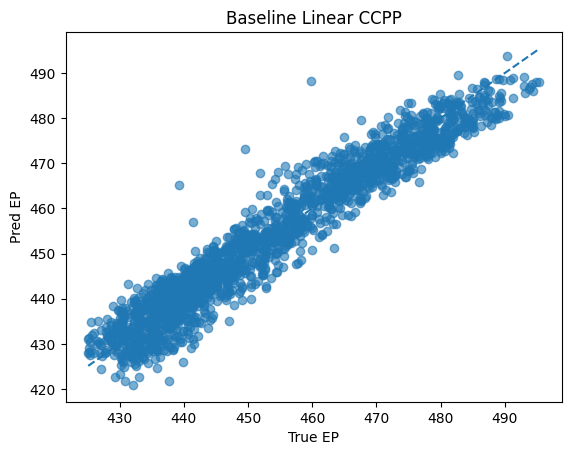

In [7]:
lin_base = LinearRegression()
lin_base.fit(Xr_train, yr_train)

yr_pred = lin_base.predict(Xr_test)

base_reg = {
    'RMSE': root_mean_squared_error(yr_test, yr_pred),
    'MAE': mean_absolute_error(yr_test, yr_pred),
    'R2': r2_score(yr_test, yr_pred)
}
print('Бейзлайн регрессия:', base_reg)

plt.scatter(yr_test, yr_pred, alpha=0.6)
plt.xlabel('True EP')
plt.ylabel('Pred EP')
plt.title('Baseline Linear CCPP')
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], linestyle='--')
plt.show()


Улучшение бейзлайна

Чтобы улучшить метрики формулируем гипотезы и усиливаем модели для классификации подбираем C penalty solver и баланс классов, для регрессии добавляем полиномиальные признаки и регуляризацию

Улучшено классификация: {'Accuracy': 0.9317051108095884, 'MacroF1': 0.9304927885391101, 'ROC-AUC': 0.9805550489895389}
Лучшие параметры классификация: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__l1_ratio': 0.8, 'clf__penalty': 'elasticnet', 'clf__solver': 'saga'}


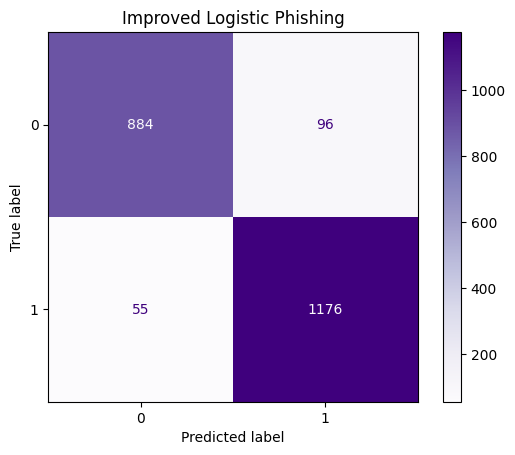

In [8]:
# Тюним логистическую регрессию по f1_macro чтобы получить сбалансированное качество по классам
cv_cls = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

pipe_logreg = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_logreg = [
    {
        'clf__solver': ['lbfgs'],
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 1.0, 3.0],
        'clf__class_weight': [None, 'balanced']
    },
    {
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.1, 1.0, 3.0],
        'clf__class_weight': [None, 'balanced']
    },
    {
        'clf__solver': ['saga'],
        'clf__penalty': ['elasticnet'],
        'clf__l1_ratio': [0.2, 0.5, 0.8],
        'clf__C': [0.1, 1.0, 3.0],
        'clf__class_weight': [None, 'balanced']
    }
]

gs_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=param_logreg,
    scoring='f1_macro',
    cv=cv_cls,
    n_jobs=-1,
    refit=True
)
gs_logreg.fit(Xc_train, yc_train)

yc1 = gs_logreg.predict(Xc_test)
yc1_proba = gs_logreg.predict_proba(Xc_test)[:, 1]

imp_cls = {
    'Accuracy': accuracy_score(yc_test, yc1),
    'MacroF1': f1_score(yc_test, yc1, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, yc1_proba)
}
print('Улучшено классификация:', imp_cls)
print('Лучшие параметры классификация:', gs_logreg.best_params_)

cm1 = confusion_matrix(yc_test, yc1, labels=[0, 1])
ConfusionMatrixDisplay(cm1, display_labels=[0, 1]).plot(cmap='Purples')
plt.title('Improved Logistic Phishing')
plt.show()


Улучшеная регрессия: {'RMSE': 4.231375687496948, 'MAE': 3.3517376540034927, 'R2': 0.9382725473913431}
Лучшая модель для регрессии: Pipeline(steps=[('sc', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('rg', Lasso(alpha=0.001, max_iter=5000))])
Лучшие параметры регрессии: {'rg__alpha': 0.001}


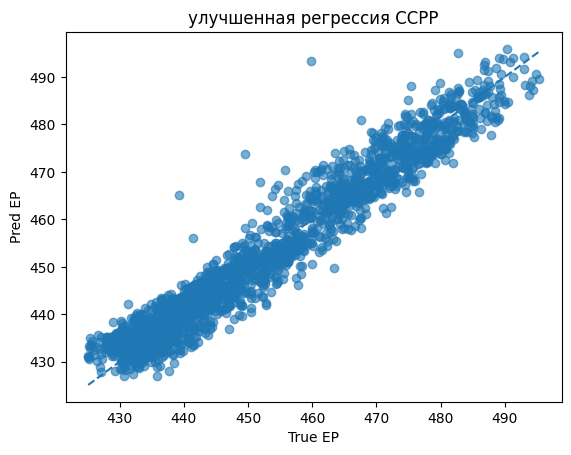

In [9]:
# Тюним регрессию полиномиальными признаками и регуляризацией чтобы найти слабую нелинейность и контролировать переобучение
cv_reg = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


def gscv(estimator, grid):
    return GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring='neg_root_mean_squared_error',
        cv=cv_reg,
        n_jobs=-1,
        refit=True
    )


pipe_poly_ridge = Pipeline([
    ('sc', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('rg', Ridge())
])
pipe_poly_lasso = Pipeline([
    ('sc', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('rg', Lasso(max_iter=5000))
])
pipe_poly_en = Pipeline([
    ('sc', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('rg', ElasticNet(max_iter=5000))
])

gs_ridge = gscv(pipe_poly_ridge, {'rg__alpha': [0.1, 1.0, 3.0, 10.0]}).fit(Xr_train, yr_train)
gs_lasso = gscv(pipe_poly_lasso, {'rg__alpha': [0.001, 0.01, 0.1, 1.0]}).fit(Xr_train, yr_train)
gs_en = gscv(pipe_poly_en, {'rg__alpha': [0.001, 0.01, 0.1, 1.0], 'rg__l1_ratio': [0.2, 0.5, 0.8]}).fit(Xr_train,
                                                                                                        yr_train)

best_gs = max([gs_ridge, gs_lasso, gs_en], key=lambda g: g.best_score_)

yr1 = best_gs.predict(Xr_test)

imp_reg = {
    'RMSE': root_mean_squared_error(yr_test, yr1),
    'MAE': mean_absolute_error(yr_test, yr1),
    'R2': r2_score(yr_test, yr1)
}
print('Улучшеная регрессия:', imp_reg)
print('Лучшая модель для регрессии:', best_gs.best_estimator_)
print('Лучшие параметры регрессии:', best_gs.best_params_)

plt.scatter(yr_test, yr1, alpha=0.6)
plt.xlabel('True EP')
plt.ylabel('Pred EP')
plt.title('улучшенная регрессия CCPP')
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], linestyle='--')
plt.show()


Сравнение бейзлайна и улучшенных моделей

Фиксируем итоговые метрики в таблицах чтобы сравнить с предыдущ вариантами

In [10]:
# Сводим метрики в таблицы
cmp_cls = pd.DataFrame([
    {'Model': 'Baseline', **base_cls},
    {'Model': 'Improved', **imp_cls}
]).set_index('Model').round(4)

cmp_reg = pd.DataFrame([
    {'Model': 'Baseline', **base_reg},
    {'Model': 'Improved', **imp_reg}
]).set_index('Model').round(4)

display(cmp_cls)
display(cmp_reg)


,Accuracy,MacroF1,ROC-AUC
Model,,,
Baseline,0.9285,0.9273,0.9808
Improved,0.9317,0.9305,0.9806


,RMSE,MAE,R2
Model,,,
Baseline,4.5026,3.5959,0.9301
Improved,4.2314,3.3517,0.9383




Попытка запила ручных вариантов моделей чтобы проверить насколько они близки по качеству к стандартным в сктитлерн

In [11]:
# Готовим данные для реализаций с нуля повторяя импьютацию и стандартизацию(как и делали до этого)
imp = SimpleImputer(strategy='most_frequent').fit(Xc_train)
Xs_tr = imp.transform(Xc_train)
Xs_te = imp.transform(Xc_test)

sc = StandardScaler().fit(Xs_tr)
Xs_tr = sc.transform(Xs_tr)
Xs_te = sc.transform(Xs_te)


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def logreg_gd_fit(X, y, lr=0.1, n_iter=3000, lam=1e-4):
    n, p = X.shape
    w = np.zeros(p)
    b = 0.0
    for _ in range(n_iter):
        z = X @ w + b
        p1 = sigmoid(z)
        grad_w = (X.T @ (p1 - y)) / n + lam * w
        grad_b = np.mean(p1 - y)
        w -= lr * grad_w
        b -= lr * grad_b
    return w, b


def logreg_predict(X, w, b, thr=0.5):
    prob = sigmoid(X @ w + b)
    return (prob >= thr).astype(int), prob


w, b = logreg_gd_fit(Xs_tr, yc_train, lr=0.1, n_iter=3000, lam=1e-4)
ys_pred, ys_prob = logreg_predict(Xs_te, w, b)

scratch_cls = {
    'Accuracy': accuracy_score(yc_test, ys_pred),
    'MacroF1': f1_score(yc_test, ys_pred, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, ys_prob)
}
print('Ручная классификация:', scratch_cls)


С нуля классификация: {'Accuracy': 0.9298959746720941, 'MacroF1': 0.9287199203804599, 'ROC-AUC': 0.9806669540277525}


In [13]:
# Обучаем линейную регрессию с нуля по MSE с L2 по градиентному спуску
sc_r = StandardScaler().fit(Xr_train)
Xr_tr_s = sc_r.transform(Xr_train)
Xr_te_s = sc_r.transform(Xr_test)


def linreg_gd_fit(X, y, lr=0.05, n_iter=5000, lam=1e-4):
    n, p = X.shape
    w = np.zeros(p)
    b = 0.0
    for _ in range(n_iter):
        pred = X @ w + b
        err = pred - y
        grad_w = (X.T @ err) / n + lam * w
        grad_b = np.mean(err)
        w -= lr * grad_w
        b -= lr * grad_b
    return w, b


wr, br = linreg_gd_fit(Xr_tr_s, yr_train, lr=0.05, n_iter=5000, lam=1e-4)
yr_s = Xr_te_s @ wr + br

scratch_reg = {
    'RMSE': root_mean_squared_error(yr_test, yr_s),
    'MAE': mean_absolute_error(yr_test, yr_s),
    'R2': r2_score(yr_test, yr_s)
}
print('С нуля регрессия:', scratch_reg)


С нуля регрессия: {'RMSE': 4.502538419164228, 'MAE': 3.595866359046147, 'R2': 0.9301075866892328}



Сопоставляем три уровня сложности Baseline Improved Scratch чтобы наглядно увидеть как тюнинг и регуляризация дают прирост качества метрик (реализации с нуля чутчут уступают по качеству, очев)

In [15]:
cmp_cls_all = pd.DataFrame([
    {'Model': 'Baseline', **base_cls},
    {'Model': 'Improved', **imp_cls},
    {'Model': 'Scratch', **scratch_cls}
]).set_index('Model').round(4)

cmp_reg_all = pd.DataFrame([
    {'Model': 'Baseline', **base_reg},
    {'Model': 'Improved', **imp_reg},
    {'Model': 'Scratch', **scratch_reg}
]).set_index('Model').round(4)

display(cmp_cls_all)
display(cmp_reg_all)


,Accuracy,MacroF1,ROC-AUC
Model,,,
Baseline,0.9285,0.9273,0.9808
Improved,0.9317,0.9305,0.9806
Scratch,0.9299,0.9287,0.9807


,RMSE,MAE,R2
Model,,,
Baseline,4.5026,3.5959,0.9301
Improved,4.2314,3.3517,0.9383
Scratch,4.5025,3.5959,0.9301


Что в итоге имеем?

Базовые модели дают неплохой старт, но после стандартизации , регуляризации и кросс валидации качество значительно выросло и при этом реализации с нуля дают примерно такие же метрики как и бейзлайн